In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import os
import shutil
import cv2
import keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score
from keras.layers import Conv2D, Flatten, Dense, Dropout, MaxPooling2D, BatchNormalization, UpSampling2D, GlobalAveragePooling2D
from keras.models import Sequential, load_model
from keras.applications import ResNet50
from keras.callbacks import EarlyStopping, Callback , ModelCheckpoint
from keras.metrics import Accuracy,binary_crossentropy, FalsePositives, FalseNegatives, TruePositives, TrueNegatives
from keras.preprocessing.image import ImageDataGenerator

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import pickle
# Load preprocessed datasets from pickle file
with open('/content/drive/MyDrive/Disertatie/preprocessed_data.pkl', 'rb') as f:
    training_images, training_labels, val_images, val_labels, test_images, test_labels = pickle.load(f)


In [4]:
#Defining Image Data Generator for image augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    horizontal_flip=True,
    vertical_flip=True,
    shear_range=0.2,
    fill_mode='nearest',
    zoom_range=0.2)

In [37]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, BatchNormalization, Dense, Dropout

# Load ResNet50 base model without top layers and with pre-trained ImageNet weights
base_model = ResNet50(include_top=False, weights='imagenet', input_shape=(224, 224, 3))

# Freeze all layers in the base model
for layer in base_model.layers:
    layer.trainable = False

# Create a sequential model and add the base model to it
model = Sequential()
model.add(base_model)

# Add custom top layers
model.add(Flatten())
model.add(BatchNormalization())

# Add dense layer with 64 units and ReLU activation
model.add(Dense(64, activation='relu'))
# Add dropout for regularization
model.add(Dropout(0.4))  # Increased dropout rate to 0.4

# Add final dense layer for binary classification with sigmoid activation
model.add(Dense(1, activation='sigmoid'))

# Print model summary
model.summary()
# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 flatten_1 (Flatten)         (None, 100352)            0         
                                                                 
 batch_normalization_2 (Bat  (None, 100352)            401408    
 chNormalization)                                                
                                                                 
 dense_2 (Dense)             (None, 64)                6422592   
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                      

In [38]:
#Setting the learning rate to reduce gradually over the training period
lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
  0.001,
  decay_steps=20*50,
  decay_rate=1,
  staircase=False)

def get_optimizer():
  return tf.keras.optimizers.Adam(lr_schedule)

In [39]:
#Compiling the model
model.compile(loss='binary_crossentropy', optimizer=get_optimizer(), metrics=['accuracy'])
early_stop = EarlyStopping(monitor='val_loss', patience=10)
checkpoint = ModelCheckpoint("./Best_model/.keras", save_best_only=True)

In [41]:
#Fitted the model on the training and and validation dataset using the image augmentor for 200 epochs
history = model.fit(datagen.flow(training_images, training_labels, batch_size = 32),
                                     validation_data=datagen.flow(val_images, val_labels),
                                     epochs=70,
                                     callbacks=[early_stop,checkpoint],
                                     verbose = 1)

Epoch 1/70
159/159 [==============================] - 114s 694ms/step - loss: 0.7547 - accuracy: 0.6657 - val_loss: 0.6084 - val_accuracy: 0.7014
Epoch 2/70
159/159 [==============================] - 110s 688ms/step - loss: 0.5575 - accuracy: 0.7165 - val_loss: 0.5261 - val_accuracy: 0.7243
Epoch 3/70
159/159 [==============================] - 112s 703ms/step - loss: 0.5300 - accuracy: 0.7307 - val_loss: 0.4900 - val_accuracy: 0.7630
Epoch 4/70
159/159 [==============================] - 108s 677ms/step - loss: 0.5077 - accuracy: 0.7386 - val_loss: 0.4633 - val_accuracy: 0.8096
Epoch 5/70
159/159 [==============================] - 106s 668ms/step - loss: 0.4957 - accuracy: 0.7510 - val_loss: 0.4704 - val_accuracy: 0.8017
Epoch 6/70
159/159 [==============================] - 108s 678ms/step - loss: 0.4890 - accuracy: 0.7546 - val_loss: 0.4414 - val_accuracy: 0.8081
Epoch 7/70
159/159 [==============================] - 109s 681ms/step - loss: 0.4833 - accuracy: 0.7595 - val_loss: 0.4569 -

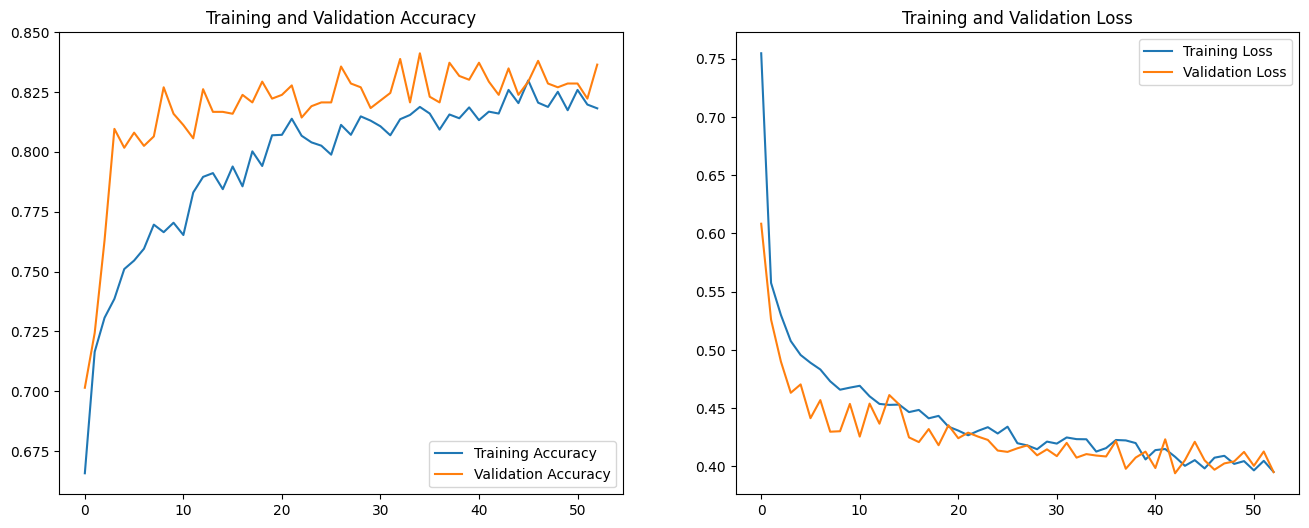

In [42]:
#Plotting the model results

#Getting the accuracy
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

#Getting the losses
loss = history.history['loss']
val_loss = history.history['val_loss']

#No of epochs it trained
epochs_range = history.epoch

#Plotting Training and Validation accuracy
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

#Plotting Training and Validation Loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [43]:
resnet_y_pred = model.predict(test_images)

50/50 [==============================] - 26s 510ms/step


In [44]:
print(resnet_y_pred)

[[0.73519564]
 [0.9069301 ]
 [0.7349679 ]
 ...
 [0.74252635]
 [0.9697448 ]
 [0.69188523]]


In [49]:
#Round up model prediction to 0 and 1 and convert result to an array
rounded = [float(np.round(x)) for x in resnet_y_pred]
rounded_resnet = np.asarray(rounded).astype(int)
print(rounded_resnet)

[1 1 1 ... 1 1 1]


<ipython-input-49-27918ab74bbe>:2: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  rounded = [float(np.round(x)) for x in resnet_y_pred]


[[324 158]
 [132 968]]


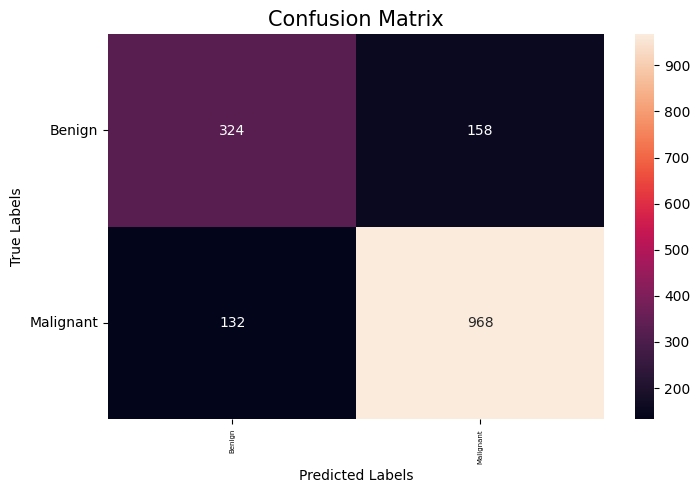

In [47]:
#Confusion matrix
cm = confusion_matrix(test_labels, rounded_v3)
print(cm)

import seaborn as sns

#Setting the labels
labels = ['Benign', 'Malignant']

#Plot the Confusion matrix graph
fig= plt.figure(figsize=(8, 5))
ax = plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt='g')
ax.set_xlabel('Predicted Labels', fontsize=10)
ax.xaxis.set_label_position('bottom')
plt.xticks(rotation=90)
ax.xaxis.set_ticklabels(labels, fontsize = 5)
ax.xaxis.tick_bottom()

ax.set_ylabel('True Labels', fontsize=10)
ax.yaxis.set_ticklabels(labels, fontsize = 10)
plt.yticks(rotation=0)

plt.title('Confusion Matrix', fontsize=15)

plt.savefig('ConMat24.png')
plt.show()

In [50]:
#Classification report
print(classification_report(test_labels, rounded_resnet))

              precision    recall  f1-score   support

           0       0.71      0.67      0.69       482
           1       0.86      0.88      0.87      1100

    accuracy                           0.82      1582
   macro avg       0.79      0.78      0.78      1582
weighted avg       0.81      0.82      0.82      1582



In [51]:
#Accuracy
accuracy = accuracy_score(test_labels, rounded_resnet)
print('Accuracy: %f' % accuracy)

Accuracy: 0.816688


In [52]:
#Precision
precision = precision_score(test_labels, rounded_resnet)
print('Precision: %f' % precision)

Precision: 0.859680


In [53]:
# Recall
recall = recall_score(test_labels, rounded_resnet, pos_label=1)
print('Recall: %f' % recall)

Recall: 0.880000


In [54]:
#Specificity
specificity = recall_score(test_labels, rounded_resnet, pos_label=0)
print('Specificity: %f' % specificity)

Specificity: 0.672199


In [55]:
Specificity: 0.717842
#F1-score
F1_score = f1_score(test_labels, rounded_resnet)
print('F1_score: %f' % F1_score)

F1_score: 0.869721


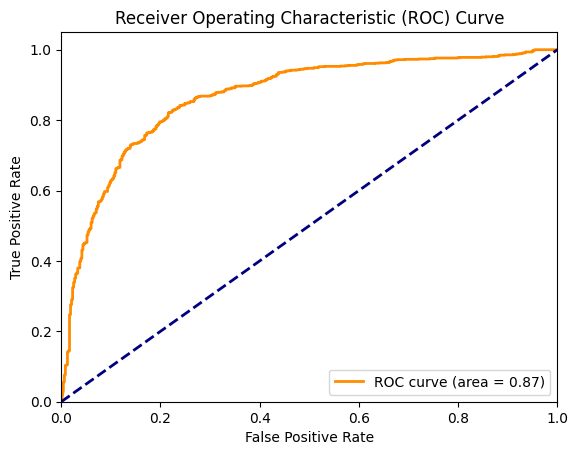

In [56]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(test_labels, resnet_y_pred)

# Calculate the area under the ROC curve
roc_auc = roc_auc_score(test_labels, resnet_y_pred)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


In [57]:
#Save the model
model.save("/content/drive/MyDrive/Disertatie/ResNet50_Model.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [58]:
# Getting the accuracy
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# Final accuracy
final_accuracy = acc[-1]
final_val_accuracy = val_acc[-1]

print("Final Training Accuracy:", final_accuracy)
print("Final Validation Accuracy:", final_val_accuracy)


Final Training Accuracy: 0.8182177543640137
Final Validation Accuracy: 0.8364928960800171
